<a href="https://colab.research.google.com/github/lalitpathak/Thesis/blob/master/Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Dataset Selection***

> Indented block

> Indented block






Data selected from 

https://www.kaggle.com/conorrot/irish-weather-hourly-data

This dataset contains hourly weather data for a number of regions across Ireland.

Two methos are implemented to collect the data from google drive.  

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import seaborn as sns
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
from keras import Sequential
from keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding, CuDNNGRU, LSTM, CuDNNLSTM, Bidirectional
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
import tensorflow as tf
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import matplotlib.pyplot as pyplot



Using TensorFlow backend.


In [0]:
"""Generalized code.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1a8-ixAnXjvv7p4Ap58P9FANN01IhQK9T
"""

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

  
  
  

In [0]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/Colab Notebooks

print(os.getcwd()) 
print(os.listdir(os.getcwd()))

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks
/content/drive/My Drive/Colab Notebooks
['.ipynb_checkpoints', 'hourly_irish_weather.csv', 'Data_Discription.csv', 'Copy of Thesis (1).ipynb', 'Copy of Thesis.ipynb', 'PROJECT_RESULT.csv', 'Thesis.ipynb']


# ***Data Preparation and Pre-Processing*** 

This is time consuming and important process and it is divided into various part such as cleaning,identifying Patterns, finding correlation, Auto-correlation and correlation, feature selection, finding trend and seasonality in data to improves the accuracy of the dataset.
In this part all these steps are implemented. 


### 1.Creating Data Frame, Displaying sample of Data and Sumarising Data Frame 

In [0]:
df = pd.read_csv('hourly_irish_weather.csv')
df.head()
df.dtypes


df['temp'] = pd.to_numeric(df['temp'])
df['dewpt'] = pd.to_numeric(df['dewpt'])
df['vappr'] = pd.to_numeric(df['vappr'])
df['dewpt'] = pd.to_numeric(df['dewpt'])
df.dtypes

Unnamed: 0      int64
date           object
station        object
county         object
longitude     float64
latitude      float64
rain          float64
temp          float64
wetb          float64
dewpt         float64
vappr         float64
rhum          float64
msl           float64
wdsp          float64
wddir         float64
ww            float64
w             float64
sun           float64
vis           float64
clht          float64
clamt         float64
dtype: object

In [0]:
# selecting the data for processing

df_cork = df[df.county == 'Cork']

# Displaying sample data first 5 rows
df_cork.head()

,Unnamed: 0,date,station,county,longitude,latitude,rain,temp,wetb,dewpt,vappr,rhum,msl,wdsp,wddir,ww,w,sun,vis,clht,clamt
0,0,1989-01-01 00:00:00,Cork_Airport,Cork,-8.485,51.842,0.0,9.1,8.7,8.3,10.9,95.0,1036.3,13.0,190.0,10.0,22.0,0.0,10000.0,22.0,7.0
1,1,1989-01-01 01:00:00,Cork_Airport,Cork,-8.485,51.842,0.0,9.0,8.7,8.4,11.0,96.0,1036.2,13.0,190.0,10.0,22.0,0.0,8000.0,4.0,8.0
2,2,1989-01-01 02:00:00,Cork_Airport,Cork,-8.485,51.842,0.0,8.9,8.5,8.1,10.8,95.0,1036.0,12.0,190.0,10.0,22.0,0.0,8000.0,4.0,8.0
3,3,1989-01-01 03:00:00,Cork_Airport,Cork,-8.485,51.842,0.0,9.0,8.7,8.4,11.0,96.0,1035.9,11.0,190.0,10.0,22.0,0.0,8000.0,4.0,8.0
4,4,1989-01-01 04:00:00,Cork_Airport,Cork,-8.485,51.842,0.0,9.0,8.6,8.2,10.8,95.0,1035.8,10.0,190.0,10.0,22.0,0.0,10000.0,14.0,8.0


In [0]:

# attribute selection  and description of dataframe  which include mean, standrad deviation and minimumand maximum values
df_cork = df_cork[['date','station','county','longitude','latitude','temp','wetb','dewpt','vappr']].copy()
df_cork.head()

df_cork_describe = df_cork[['temp','wetb','dewpt','vappr']].copy()
#a= df_cork_describe.describe()
#print(a.to_latex())



### 2. Null Values check


In [0]:
# replace field that's entirely space (or empty) with NaN
    df_cork = df_cork.replace(r'^\s*$', np.nan, regex=True)   

Text(33.0, 0.5, 'Number of Rows')

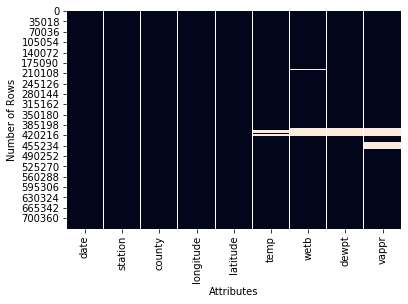

In [0]:
df_cork.isnull ().values.any()

heat_map = sns.heatmap(df_cork.isnull(), cbar=False)
plt.xlabel('Attributes')
plt.ylabel('Number of Rows')


### 3.Duplicate check 


In [0]:
# creating month, day and year, hours from date column for further processing 

df_cork['date'] = df_cork['date'].astype('str')
df_cork[['year','month','day']] = df_cork.date.str.split("-",expand=True,)
df_cork[['day','Hrs']] = df_cork.day.str.split(" ",expand=True,)
df_cork.head()



,date,station,county,longitude,latitude,temp,wetb,dewpt,vappr,year,month,day,Hrs
0,1989-01-01 00:00:00,Cork_Airport,Cork,-8.485,51.842,9.1,8.7,8.3,10.9,1989,01,01,00:00:00
1,1989-01-01 01:00:00,Cork_Airport,Cork,-8.485,51.842,9.0,8.7,8.4,11.0,1989,01,01,01:00:00
2,1989-01-01 02:00:00,Cork_Airport,Cork,-8.485,51.842,8.9,8.5,8.1,10.8,1989,01,01,02:00:00
3,1989-01-01 03:00:00,Cork_Airport,Cork,-8.485,51.842,9.0,8.7,8.4,11.0,1989,01,01,03:00:00
4,1989-01-01 04:00:00,Cork_Airport,Cork,-8.485,51.842,9.0,8.6,8.2,10.8,1989,01,01,04:00:00


In [0]:
# Creating Data frame with Null values from actual dataframe 
df_cork_null = df_cork[df_cork.isna().any(axis=1)]
df_cork_null.head()

,date,station,county,longitude,latitude,temp,wetb,dewpt,vappr,year,month,day,Hrs
158225,2007-01-19 17:00:00,Cork_Airport,Cork,-8.485,51.842,11.2,11.6,11.1,NaN,2007,01,19,17:00:00
181068,2009-08-28 12:00:00,Cork_Airport,Cork,-8.485,51.842,15.0,NaN,8.8,11.3,2009,08,28,12:00:00
181069,2009-08-28 13:00:00,Cork_Airport,Cork,-8.485,51.842,13.4,NaN,9.9,12.2,2009,08,28,13:00:00
181070,2009-08-28 14:00:00,Cork_Airport,Cork,-8.485,51.842,14.8,NaN,7.8,10.6,2009,08,28,14:00:00
181071,2009-08-28 15:00:00,Cork_Airport,Cork,-8.485,51.842,14.0,NaN,8.4,11.1,2009,08,28,15:00:00


In [0]:
# creating Dataframe with NotNull values and substracting it from Null value dataframe to calculate Null values and Not null values in dataframe 

df_cork_notnull = df_cork.dropna(axis = 0, how ='any')

# Displaying dataframe count with and without null values 

print("Old data frame length:", len(df_cork), "\nNew data frame length:",  
       len(df_cork_notnull), "\nNumber of rows with at least 1 NA value: ", 
       (len(df_cork_null)-len(df_cork_notnull)))

Old data frame length: 735357 
New data frame length: 683399 
Number of rows with at least 1 NA value:  -631441


In [0]:
# Identification of duplicate values from the Notnull dataframe 

if len(df_cork_notnull[df_cork_notnull.duplicated()]) > 0:
        print("\n***Number of duplicated entries: ", len(df_cork_notnull[df_cork_notnull.duplicated()]))
        display(df_cork_notnull[df_cork_notnull.duplicated(keep=False)].sort_values(by=list(df.columns)).head())
else:
        print("\nNo duplicated entries found")


No duplicated entries found


### 4.Correlation Plot

In [0]:
import pandas as pd
import numpy as np

rs = np.random.RandomState(0)
corr = df_cork_notnull.corr()
corr.style.background_gradient(cmap='coolwarm')

,longitude,latitude,temp,wetb,dewpt,vappr
longitude,1,0.79782,-0.0724416,-0.0807874,-0.0777636,-0.0766135
latitude,0.79782,1,-0.0743315,-0.0869614,-0.0866764,-0.0816145
temp,-0.0724416,-0.0743315,1,0.971743,0.87343,0.858213
wetb,-0.0807874,-0.0869614,0.971743,1,0.959528,0.94451
dewpt,-0.0777636,-0.0866764,0.87343,0.959528,1,0.975122
vappr,-0.0766135,-0.0816145,0.858213,0.94451,0.975122,1



### 5 Identifying Outliers in Data set,  Univarient and Pairwise joint distribution plot AND Analyzing time series numeric data Hourly Daily, Monthly, Yearly   

In [0]:
#  Creating New dataframe with the attribute used as input and output of the model for identification of Outliers, Distribution of data and analysing Time series data hourly,daily, monthly and Yearly 
df = df_cork_notnull.copy()
df= df.drop(['month','station', 'county', 'longitude','latitude','day','year','Hrs'], axis=1)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M')
#df=df.set_index('date',inplace=False)
df = df.resample('d', on='date').mean().dropna(how='all')
df.head()

,temp,wetb,dewpt,vappr
date,,,,
1989-01-01,8.700000,7.704167,6.506250,9.747917
1989-01-02,8.152083,7.093750,5.810417,9.245833
1989-01-03,9.556250,8.718750,7.754167,10.625000
1989-01-04,5.947917,4.614583,2.706250,7.452083
1989-01-05,9.166667,8.522917,7.797917,10.725000


In [0]:
# Customise function to check the outliers and analyzing the time seires data 

def numeric_eda(df, hue=None):
    """Given dataframe, generate EDA of numeric data"""
    print("\nTo check: \nDistribution of numeric data")
    display(df.describe().T)
    columns = df.select_dtypes(include=np.number).columns
    figure = plt.figure(figsize=(10, 4))
    figure.add_subplot(1, len(columns), 1)
    for index, col in enumerate(columns):
        if index > 0:
            figure.add_subplot(1, len(columns), index + 1)
        sns.boxplot(y=col, data=df, boxprops={'facecolor': 'None'})
    figure.tight_layout()
    plt.show()
    
    if len(df.select_dtypes(include='category').columns) > 0:
        for col_num in df.select_dtypes(include=np.number).columns:
            for col in df.select_dtypes(include='category').columns:
                fig = sns.catplot(x=col, y=col_num, kind='violin', data=df, height=5, aspect=2)
                fig.set_xticklabels(rotation=90)
                plt.rcParams.update({'figure.figsize': (10,8)})
                plt.show()
     
 # Plot the pairwise joint distributions
    print("\nTo check pairwise joint distribution of numeric data")
    if hue==None:
      sns.pairplot(df.select_dtypes(include=np.number),kind="reg", plot_kws={'line_kws':{'color':'red'}})
    else:
      sns.pairplot(df.select_dtypes(include=np.number).join(df[[hue]]), hue=hue,diag_kind = 'kde',kind="reg",
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'},size = 3)
      plt.show()



To check: 
Distribution of numeric data


,count,mean,std,min,25%,50%,75%,max
temp,10592.0,10.143317,3.920875,-4.435417,7.311979,10.138021,13.313021,20.73750
wetb,10592.0,8.953527,3.810886,-5.005208,6.205729,9.074479,11.957292,18.40000
dewpt,10592.0,7.629684,4.123481,-6.904167,4.655990,7.891667,10.760937,17.86250
vappr,10592.0,10.866155,2.964267,2.597917,8.574740,10.702083,12.957552,20.46875


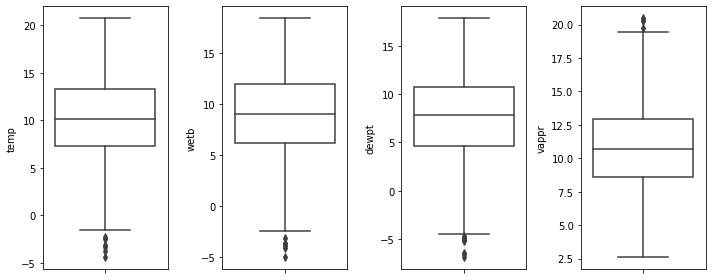


To check pairwise joint distribution of numeric data


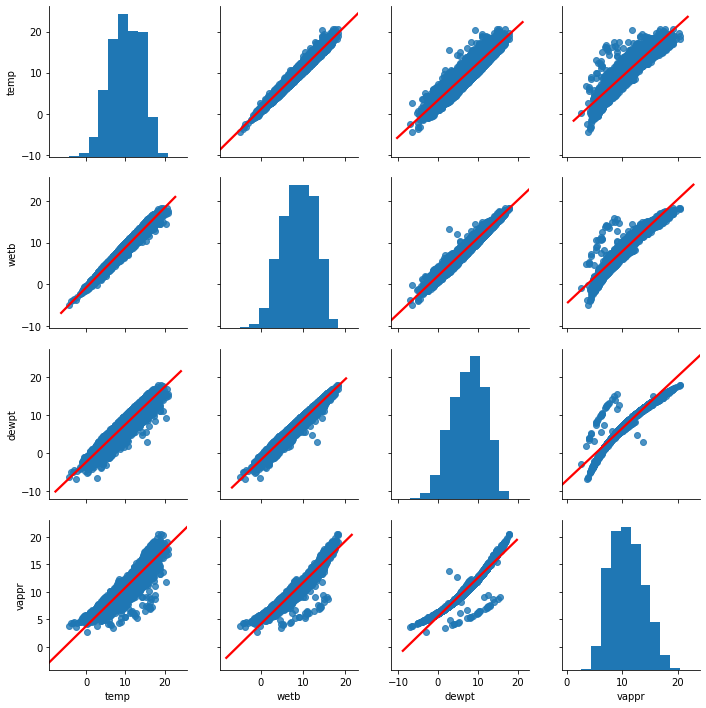

In [0]:
#plt.rcParams.update({'figure.figsize': (1,4)})
numeric_eda(df)

In [0]:
# created new dataframe to check monthly, daily, hourly patterns from the dataset 
df_cork_notnull['date'] =  pd.to_datetime(df_cork_notnull['date'], format='%Y/%m/%d %H:%M')
df1= df_cork_notnull.drop(['station', 'county', 'longitude','latitude'], axis=1)
df1.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,date,temp,wetb,dewpt,vappr,year,month,day,Hrs
0,1989-01-01 00:00:00,9.1,8.7,8.3,10.9,1989,01,01,00:00:00
1,1989-01-01 01:00:00,9.0,8.7,8.4,11.0,1989,01,01,01:00:00
2,1989-01-01 02:00:00,8.9,8.5,8.1,10.8,1989,01,01,02:00:00
3,1989-01-01 03:00:00,9.0,8.7,8.4,11.0,1989,01,01,03:00:00
4,1989-01-01 04:00:00,9.0,8.6,8.2,10.8,1989,01,01,04:00:00


In [0]:
 def time_series_plot(df):
    """Given dataframe, generate times series plot of numeric data by daily, monthly and yearly frequency"""
    print("\nTo check time series of numeric data  by daily, monthly and yearly frequency")
    if len(df.select_dtypes(include='datetime64').columns)>0:
        for col in df.select_dtypes(include='datetime64').columns:
            for p in ['H','D', 'M', 'Y']:
                if p=='H':
                     print("Plotting Hourly data")
                elif p=='D':
                    print("Plotting daily data")
                elif p=='M':
                    print("Plotting monthly data")
                else:
                    print("Plotting yearly data")
                for col_num in df.select_dtypes(include=np.number).columns:
                    __ = df.copy()
                    __ = __.set_index(col)
                    __T = __.resample(p).mean()
                    ax = __T[[col_num]].plot()
                    ax.set_ylim()
                    ax.get_yaxis().set_major_formatter(
                    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
                    plt.ylabel(col_num)
                    plt.legend()
                    plt.show()
                    
                    
                    


To check time series of numeric data  by daily, monthly and yearly frequency
Plotting Hourly data


/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


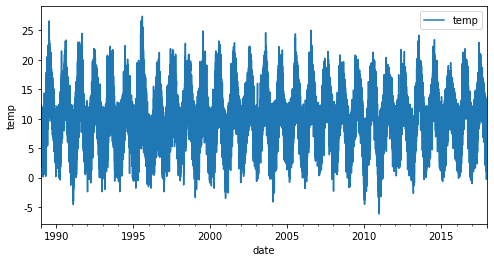

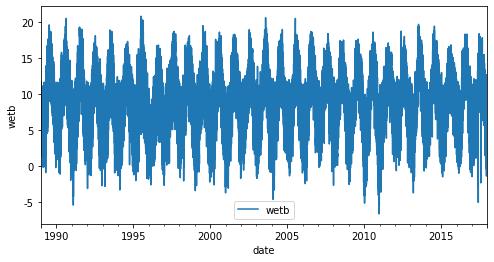

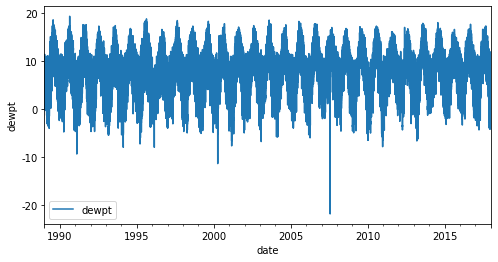

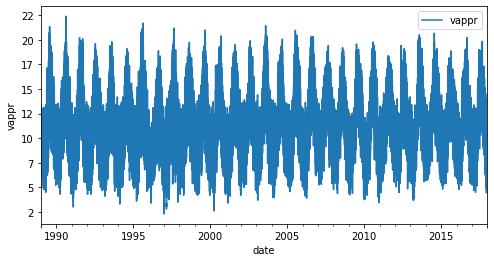

Plotting daily data


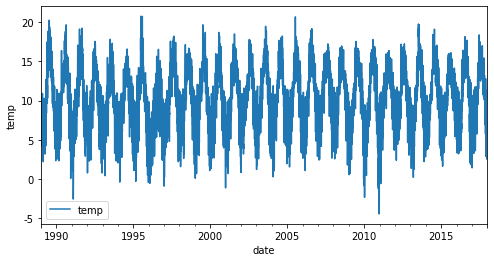

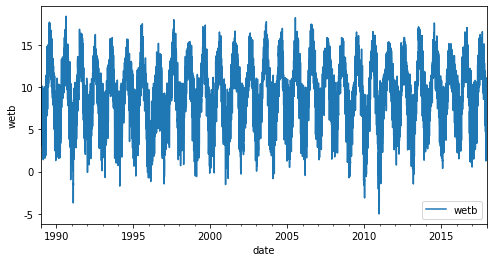

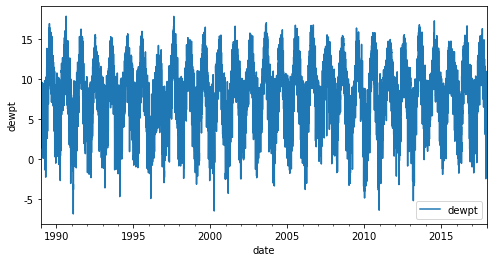

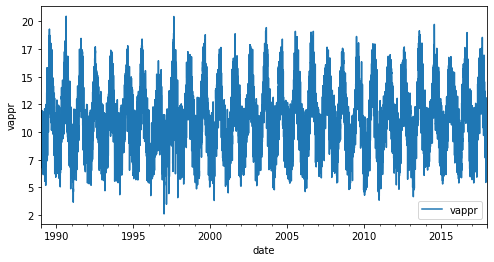

Plotting monthly data


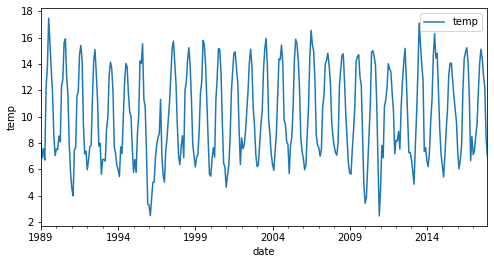

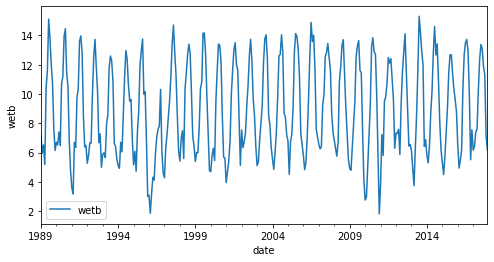

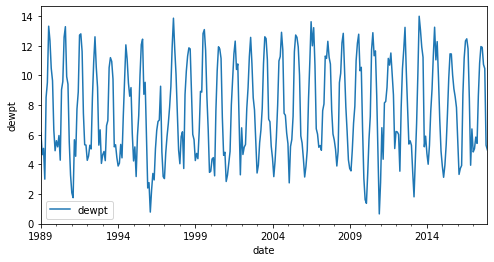

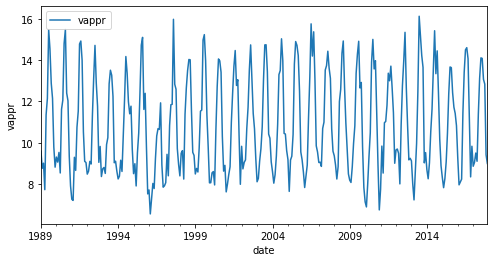

Plotting yearly data


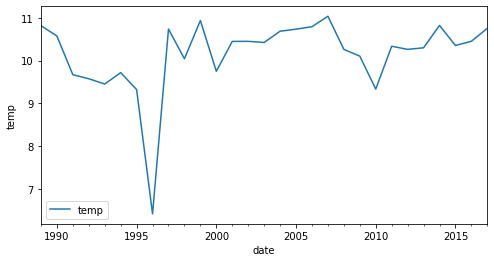

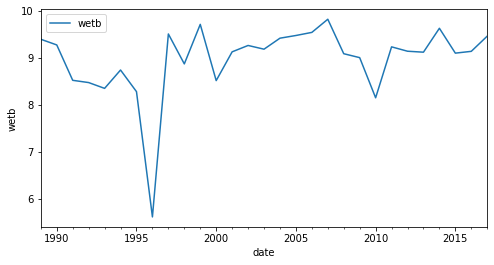

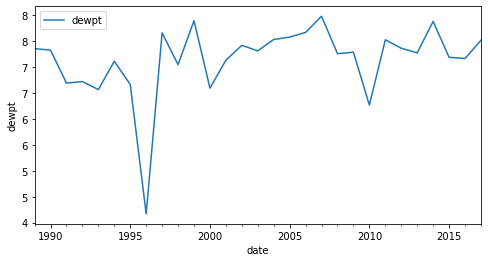

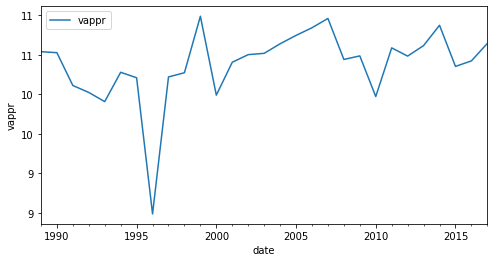

In [0]:
plt.rcParams.update({'figure.figsize': (8,4)})
time_series_plot(df1)

### 6.Year-wise Trend and Monthwise Seasonality Distribution 

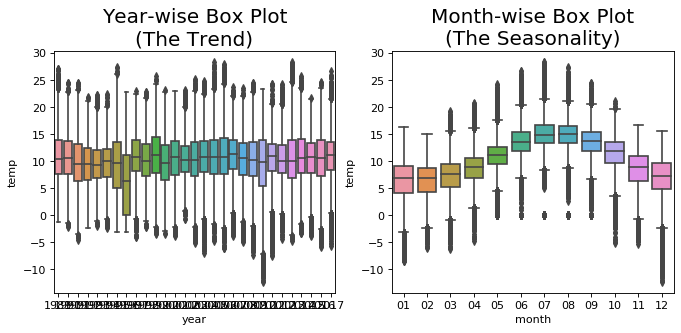

In [0]:
years = df1['year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(10,4), dpi= 80)
sns.boxplot(x='year', y='temp', data=df1, ax=axes[0])
sns.boxplot(x='month', y='temp', data=df1.loc[~df1.year.isin([1989, 2017]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18);
plt.show()

### 7.Time Series Decomposition and Extracting Components 

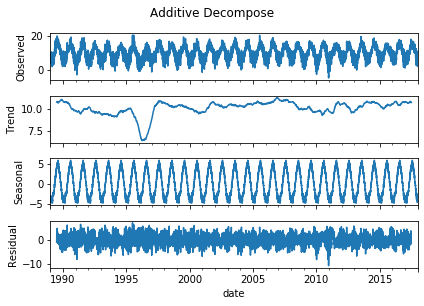

In [0]:
import statsmodels.api as sm


#result_mul = sm.tsa.seasonal_decompose(Daily_resampled_temp_data, model='multiplicative',extrapolate_trend='freq')
result_add = sm.tsa.seasonal_decompose(df['temp'], model='additive',freq=365)
plt.rcParams.update({'figure.figsize': (6,4)})
#result_mul.plot().suptitle('Multiplicative Decompose', fontsize=, y=0.98)
result_add.plot().suptitle("\n".join(['Additive Decompose']), y=1.05)
plt.show()

In [0]:
# Extract the Components ----
# Actual Values = Product of (Seasonal * Trend * Resid)
df_reconstructed = pd.concat([result_add.seasonal, result_add.trend, result_add.resid, result_add.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

,seas,trend,resid,actual_values
date,,,,
1989-01-01,-3.863666,NaN,NaN,8.700000
1989-01-02,-4.078561,NaN,NaN,8.152083
1989-01-03,-3.612116,NaN,NaN,9.556250
1989-01-04,-2.937552,NaN,NaN,5.947917
1989-01-05,-3.207242,NaN,NaN,9.166667


### 8.Stationary test  
### Augmented Dickey-fuller (ADF)
### Kwiatkowski Phillips schmeidt shin (KPSS)
### Splitting and Comparing dataset on the basis of summary statistics (mean and variance)

In [0]:
from statsmodels.tsa.stattools import adfuller, kpss

# ADF Test
result = adfuller(df.temp, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
    

ADF Statistic: -6.382936184300726
p-value: 2.1994877621950955e-08
Critial Values:
   1%, -3.4309692851727305
Critial Values:
   5%, -2.8618136888117753
Critial Values:
   10%, -2.5669156794123666


In [0]:
from statsmodels.tsa.stattools import adfuller
def test_adf(series, title=''):
    dfout={}
    dftest=sm.tsa.adfuller(series.dropna(), autolag='AIC', regression='ct')
    for key,val in dftest[4].items():
        dfout[f'critical value ({key})']=val
    if dftest[1]<=0.05:
        print("Strong evidence against Null Hypothesis")
        print("Reject Null Hypothesis - Data is Stationary")
        print("Data is Stationary", title)
    else:
        print("Strong evidence for  Null Hypothesis")
        print("Accept Null Hypothesis - Data is not Stationary")
        print("Data is NOT Stationary for", title)

In [0]:
test_adf(df['temp'], "Temperature value")

Strong evidence against Null Hypothesis
Reject Null Hypothesis - Data is Stationary
Data is Stationary Temperature value


In [0]:
 # KPSS Test
result = kpss(df.temp, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')



KPSS Statistic: 0.259459
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [0]:
one, two, three = np.split(
        df['temp'].sample(
        frac=1), [int(.25*len(df['temp'])),
        int(.75*len(df['temp']))])

mean1, mean2, mean3 = one.mean(), two.mean(), three.mean()
var1, var2, var3 = one.var(), two.var(), three.var()
 
print (mean1, mean2, mean3)
print(var1, var2, var3)

10.128629677586291 10.141761415841078 10.161114105283005
15.196366860516454 15.623137675382361 15.061395514704328


### 9.Autocorrelation (ACF) and partial autocorrelation (PACF)

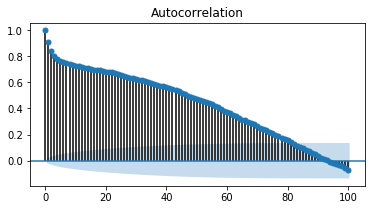

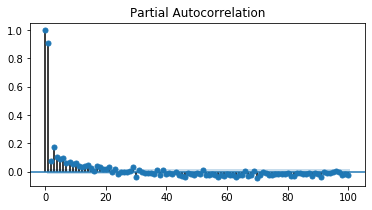

In [0]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Calculate ACF and PACF upto 50 lags
# acf_50 = acf(df.value, nlags=50)
# pacf_50 = pacf(df.value, nlags=50)
plt.rcParams.update({'figure.figsize': (6,3)})
# Draw Plot
acf = plot_acf(df.temp, lags=100)
pacf = plot_pacf(df.temp, lags=100)

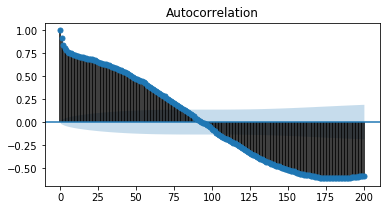

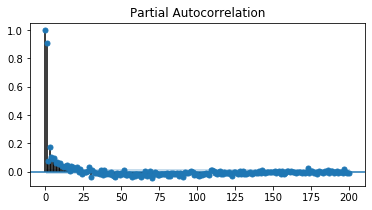

In [0]:
plt.rcParams.update({'figure.figsize': (6,3)})
acf = plot_acf(df.temp, lags=200)
pacf = plot_pacf(df.temp, lags=200)

### 10.Feature Selection

In [0]:
irish_data=pd.read_csv('hourly_irish_weather.csv')

irish_data = irish_data.replace(r'^\s*$', np.nan, regex=True)
irish_data = irish_data.dropna(axis = 0, how ='any')
irish_data1=irish_data[['temp',	'wetb',	'dewpt',	'vappr',	'rhum',	'msl',	'wdsp',	'wddir',	'ww',	'w',	'sun',	'vis',	'clht',	'clamt']]
irish_data1.head()
df2 = df_cork_notnull.copy()
df2= df2.drop(['month','station', 'county', 'longitude','latitude','day','year','Hrs'], axis=1)
df2['date'] = pd.to_datetime(df2['date'], format='%Y-%m-%d %H:%M')
#df=df.set_index('date',inplace=False)
df2 = df2.resample('d', on='date').mean().dropna(how='all')
df2.head()

,temp,wetb,dewpt,vappr
date,,,,
1989-01-01,8.700000,7.704167,6.506250,9.747917
1989-01-02,8.152083,7.093750,5.810417,9.245833
1989-01-03,9.556250,8.718750,7.754167,10.625000
1989-01-04,5.947917,4.614583,2.706250,7.452083
1989-01-05,9.166667,8.522917,7.797917,10.725000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


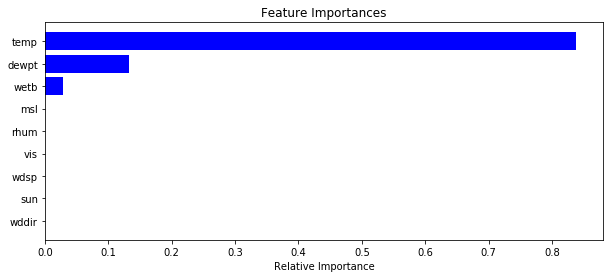

In [0]:
from sklearn.ensemble import RandomForestRegressor
X = irish_data1.iloc[:,[0,2,3,4,5,6,7,8,9,10,11,12,13]].values
y = irish_data1.iloc[:,[1]].values
model = RandomForestRegressor(random_state=0, max_depth=30)
model.fit(X,y)

features = irish_data1.columns
importances = model.feature_importances_
indices = np.argsort(importances)[-9:]  # top 10 features
plt.rcParams.update({'figure.figsize': (10,4)})
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

###  11.Detrend  

Text(0.5, 1.0, 'Temperature detrended by subtracting the least squares fit')

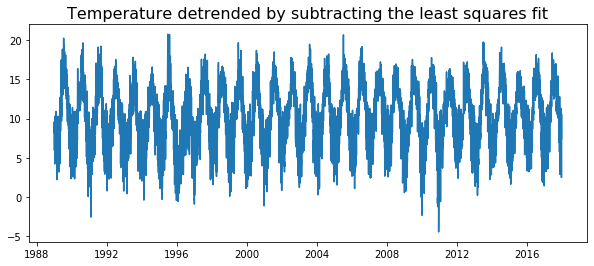

In [0]:
# Using scipy: Subtract the line of best fit
from scipy import signal
detrend= signal.detrend(df.temp)
plt.rcParams.update({'figure.figsize': (10,4)})
plt.plot(df.temp)
plt.title('Temperature detrended by subtracting the least squares fit', fontsize=16)

#detrended = Daily_resampled_temp_data.values - result_add.trend
##plt.plot(detrended)
#plt.title('detrended by subtracting the trend component', fontsize=16)

### 12.Dseasonalized

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


[]

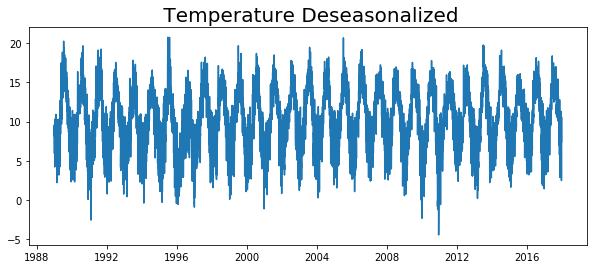

In [0]:
df.seasonalised = df.temp - result_add.seasonal

# Plot
plt.plot(df.temp)
plt.rcParams.update({'figure.figsize': (10,4)})
plt.title(' Temperature Deseasonalized', fontsize=20)
plt.plot()

# ***Model Building and Evaluation***


## **LSTM**

### Implementation

In [0]:

#	Frame a time series as a supervised learning dataset.
#	Arguments:
#		data: Sequence of observations as a list or NumPy array.
#		n_in: Number of lag observations as input (X).
#		n_out: Number of observations as output (y).
#		dropnan: Boolean whether or not to drop rows with NaN values.
#	Returns:
#		Pandas DataFrame of series framed for supervised learning.
#	

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg



In [0]:

# load dataset
values = df.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[5,6,7]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var1(t)
1   0.521807   0.543015   0.541470   0.400093  0.500041
2   0.500041   0.516934   0.513375   0.371998  0.555822
3   0.555822   0.586363   0.591857   0.449172  0.412480
4   0.412480   0.411011   0.388038   0.271625  0.540346
5   0.540346   0.577996   0.593624   0.454768  0.515104


In [0]:
# split into train and test sets
values = reframed.values
n_train_days = 7300
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(7300, 1, 4) (7300,) (3291, 1, 4) (3291,)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 7300 samples, validate on 3291 samples
Epoch 1/50
7300/7300 - 10s - loss: 0.1759 - val_loss: 0.0556
Epoch 2/50
7300/7300 - 0s - loss: 0.0597 - val_loss: 0.0540
Epoch 3/50
7300/7300 - 0s - loss: 0.0584 - val_loss: 0.0532
Epoch 4/50
7300/7300 - 0s - loss: 0.0577 - val_loss: 0.0526
Epoch 5/50
7300/7300 - 0s - loss: 0.0570 - val_loss: 0.0521
Epoch 6/50
7300/7300 - 0s - loss: 0.0564 - val_loss: 0.0516
Epoch 7/50
7300/7300 - 0s - loss: 0.0558 - val_loss: 0.0510
Epoch 8/50
7300/7300 - 0s - loss: 0.0553 - val_loss: 0.0505
Epoch 9/50
7300/7300 - 0s - loss: 0.0547 - val_loss: 0.0501
Epoch 10/50
7300/7300 - 0s - loss: 0.0542 - val_loss: 0.0496
Epoch 11/50
7300/7300 - 0s - loss: 0.0536 - val_loss: 0.0491
Epoch 12/50
7300/7300 - 0s - loss: 0.0532 - val_loss: 0.0487
Epoch 13/50
7300/7300 - 0s - loss: 0.0527 - val_loss:

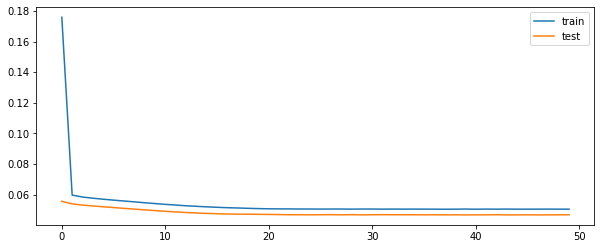

In [0]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
#plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [0]:

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))


In [0]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [0]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

### Prediction Plot

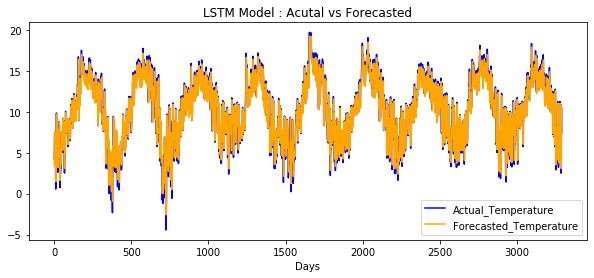

In [0]:
plt.rcParams.update({'figure.figsize': (10,4)})
plt.plot(inv_y, color='blue',label='Actual_Temperature')
plt.plot(inv_yhat, color='orange', label='Forecasted_Temperature')
#plt.xlabel('Days')
plt.title('LSTM Model : Acutal vs Forecasted')
plt.xlabel('Days')
#plt.ylabel('Actual vs Forecasted')
plt.legend()
plt.show()

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50)                11000     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 11,051
Trainable params: 11,051
Non-trainable params: 0
_________________________________________________________________


### Evaluation 

In [0]:
from sklearn.metrics import mean_squared_error
# calculate RMSE
rmse = sqrt(mean_squared_error( inv_y,inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.540


In [0]:
# Mean Squared Error

mse = mean_squared_error(test_y, yhat)
print('MSE: %f' % mse)

MSE: 0.003743


In [0]:
# Mean forecast Error 
forecast_errors = [inv_y[i]-inv_yhat[i] 
                   for i in range(len(inv_y))]
bias = sum(forecast_errors) * 1.0/len(inv_y)
print('Bias: %f' % bias)


Bias: 0.076305


In [0]:
from sklearn.metrics import mean_absolute_error

# Mean Absolute Error
mae = mean_absolute_error(test_y, yhat)
print('MAE: %f' % mae)


MAE: 0.046841


## **SARIMAX**

### Implementation

In [0]:
steps=-1
dataset_for_prediction= df.copy()
dataset_for_prediction['act_temp']=df['temp'].shift(steps)
dataset_for_prediction.head(3)


,temp,wetb,dewpt,vappr,act_temp
date,,,,,
1989-01-01,8.700000,7.704167,6.506250,9.747917,8.152083
1989-01-02,8.152083,7.093750,5.810417,9.245833,9.556250
1989-01-03,9.556250,8.718750,7.754167,10.625000,5.947917


In [0]:
X = dataset_for_prediction[['temp','wetb','dewpt','vappr']].copy()

X.index=dataset_for_prediction.index

y = dataset_for_prediction[['act_temp']].copy()
y.index=dataset_for_prediction.index


In [0]:
train_size=int(len(df) *0.7)
test_size = int(len(df)) - train_size
train_X, train_y = X[:train_size].dropna(), y[:train_size].dropna()
test_X, test_y = X[train_size:].dropna(), y[train_size:].dropna()

In [0]:
! pip install pmdarima
from pmdarima.arima import auto_arima
step_wise=auto_arima(train_y, 
 exogenous= train_X,
 start_p=1, start_q=1, 
 max_p=5, max_q=5,
 d=1, max_d=7,
 trace=True, 
 error_action='ignore', 
 suppress_warnings=True, 
 stepwise=True
 #disp=False, transparams=False, trend='c'
 )

     |████████████████████████████████| 1.5MB 1.4MB/s 
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=27885.577, BIC=27940.865, Fit time=11.448 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=28749.137, BIC=28790.603, Fit time=3.451 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=28739.941, BIC=28788.318, Fit time=4.009 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=27973.418, BIC=28021.795, Fit time=9.628 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=28747.137, BIC=28781.692, Fit time=2.922 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=27878.104, BIC=27940.303, Fit time=14.536 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=28287.793, BIC=28343.081, Fit time=6.900 seconds
Fit ARIMA: order=(3, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=27871.508, BIC=27940.618, Fit time=15.649 seconds
Fit ARIMA: order=(3, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=28252.182,

In [0]:
step_wise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 7414
Model:               SARIMAX(3, 1, 1)   Log Likelihood              -13925.754
Date:                Wed, 08 Jan 2020   AIC                          27871.508
Time:                        23:24:30   BIC                          27940.618
Sample:                    01-01-1989   HQIC                         27895.254
                         - 04-19-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   6.738e-05      0.002      0.034      0.973      -0.004       0.004
temp           0.2432      0.113      2.144      0.032       0.021       0.466
wetb          -1.1322      0.168     -6.747      0.000      -1.461      -0.803
dewpt          0.5892      0.059      9.908      0.000       0.473       0.706
vappr          0.1012      0.052      1.928      0.054      -0.002       0.204
ar.L1          0.8202      0.069     11.837      0.000       0.684       0.956
ar.L2         -0.2404      0.064     -3.753      0.000      -0.366      -0.115
ar.L3          0.0638      0.025      2.554      0.011       0.015       0.113
ma.L1         -0.8931      0.011    -83.832      0.000      -0.914      -0.872
sigma2         2.5049      0.034     72.945      0.000       2.438       2.572
===================================================================================
Ljung-Box (Q):                       96.28   Jarque-Bera (JB):               315.04
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                             0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [0]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model= SARIMAX(train_y, 
 exog=train_X,
 order=(3,1,1), enforce_invertibility=False, enforce_stationarity=False)

In [0]:
results= model.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [0]:
test_X = test_X[:-1]

### Prediction_plot

In [0]:
predictions= results.predict(start =train_size, end=train_size+test_size+(steps)-1, exog=test_X)

In [0]:
act= pd.DataFrame(y.iloc[train_size:, 0])

In [0]:
predictions

2009-04-20     9.599648
2009-04-21     8.908602
2009-04-22     9.163396
2009-04-23     9.185439
2009-04-24     8.992662
                ...    
2017-12-26    10.305668
2017-12-27     9.986482
2017-12-28    10.634492
2017-12-29     9.427995
2017-12-30     8.709680
Freq: D, Length: 3177, dtype: float64

In [0]:
predictions=pd.DataFrame(predictions,columns=list('F'))
predictions.reset_index(drop=True, inplace=True)

In [0]:
predictions.index=test_X.index
predictions['act_temp'] = act['act_temp']


In [0]:
predictions

,F,act_temp
date,,
2009-04-20,9.599648,11.634375
2009-04-21,8.908602,10.269792
2009-04-22,9.163396,10.006250
2009-04-23,9.185439,9.337500
2009-04-24,8.992662,8.447917
...,...,...
2017-12-26,10.305668,3.397917
2017-12-27,9.986482,2.502083
2017-12-28,10.634492,6.788542


In [0]:
predictions.rename(columns={'F':'Forecasted_Temperature', 'act_temp':'Actual_Temperature'}, inplace=True)
predictions

,Forecasted_Temperature,Actual_Temperature
date,,
2009-04-20,9.599648,11.634375
2009-04-21,8.908602,10.269792
2009-04-22,9.163396,10.006250
2009-04-23,9.185439,9.337500
2009-04-24,8.992662,8.447917
...,...,...
2017-12-26,10.305668,3.397917
2017-12-27,9.986482,2.502083
2017-12-28,10.634492,6.788542


Text(0.5, 1.0, 'SARIMAX Model : Acutal vs Forecasted')

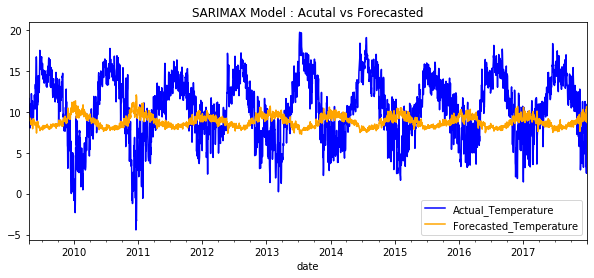

In [0]:

predictions['Actual_Temperature'].plot(figsize=(10,4), legend=True, color='blue')
predictions['Forecasted_Temperature'].plot(legend=True, color='orange', figsize=(10,4))

plt.title('SARIMAX Model : Acutal vs Forecasted')



### Evaluation 

In [0]:
from sklearn.metrics import mean_squared_error
# calculate RMSE
rmse = sqrt(mean_squared_error(predictions['Actual_Temperature'], predictions['Forecasted_Temperature']))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 4.813


In [0]:
# Mean Squared Error

mse = mean_squared_error(predictions['Actual_Temperature'],predictions['Forecasted_Temperature'])
print('MSE: %f' % mse)

MSE: 23.162797


In [0]:
# Mean forecast Error 
forecast_errors = [predictions['Forecasted_Temperature'][i]-predictions['Actual_Temperature'][i] 
                   for i in range(len(predictions['Forecasted_Temperature']))]
bias = sum(forecast_errors) * 1.0/len(predictions['Forecasted_Temperature'])
print('Bias: %f' % bias)


Bias: -1.608394


In [0]:
from sklearn.metrics import mean_absolute_error

# Mean Absolute Error
mae = mean_absolute_error(predictions['Forecasted_Temperature'], predictions['Actual_Temperature'])
print('MAE: %f' % mae)


MAE: 4.016465


## **TIBAT Implementation**

### Implementation

In [0]:
# Dividing Data into Training and Testing 

y = df['temp']
train = y[:7300]
test = y[7300:]

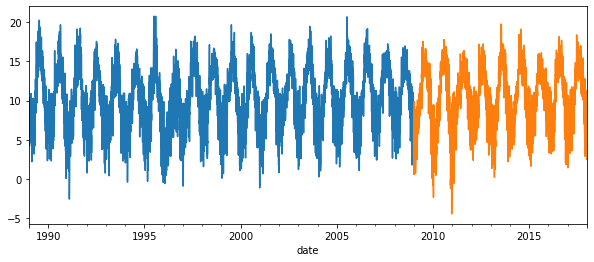

In [0]:
#plotting the data
plt.rcParams.update({'figure.figsize': (10,4)})
train.plot()
test.plot()

In [0]:
!pip3 install tbats
from tbats import TBATS, BATS
# Fit the model
estimator = TBATS(seasonal_periods=(7, 365.25))
model = estimator.fit(train)
# Forecast 3291 days ahead
y_forecast = model.forecast(steps=3291)

     |████████████████████████████████| 51kB 1.2MB/s 


In [0]:
df_test = test.to_frame() 
df_test = df_test.reset_index()

In [0]:
df_test = df_test[:-1]
df_test

,date,temp
0,2008-12-27,2.888542
1,2008-12-28,4.287500
2,2008-12-29,5.465625
3,2008-12-30,7.547917
4,2008-12-31,7.391667
...,...,...
3286,2017-12-26,3.315625
3287,2017-12-27,3.397917
3288,2017-12-28,2.502083
3289,2017-12-29,6.788542


In [0]:
from scipy import stats
stats.describe(y_forecast)

DescribeResult(nobs=3291, minmax=(5.73587286353292, 14.995891974110707), mean=9.979162707060466, variance=9.988839241994913, skewness=0.25877330306346896, kurtosis=-1.4533388647656662)

In [0]:
df = pd.DataFrame(y_forecast,columns=list('F')) 

In [0]:
df_result = pd.concat([df_test, df], axis=1)
df_result.rename(columns={'F':'Forecasted_Temperature',
                          'temp':'Actual_Temmperature'}, 
                 inplace=True)

#df_result=df_result.set_index('date',inplace=False)
df_result

,date,Actual_Temmperature,Forecasted_Temperature
0,2008-12-27,2.888542,5.735873
1,2008-12-28,4.287500,6.016367
2,2008-12-29,5.465625,6.104297
3,2008-12-30,7.547917,6.281217
4,2008-12-31,7.391667,6.334087
...,...,...,...
3286,2017-12-26,3.315625,6.423637
3287,2017-12-27,3.397917,6.423074
3288,2017-12-28,2.502083,6.410649
3289,2017-12-29,6.788542,6.378830


### Prediction Plot

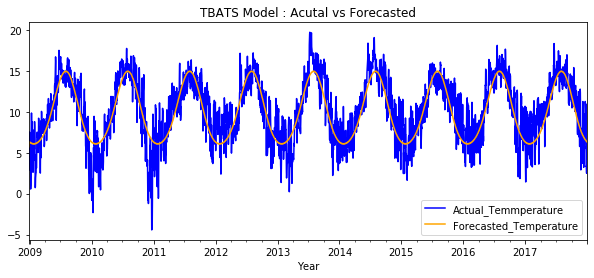

In [0]:
df_result.plot(x='date',y=['Actual_Temmperature','Forecasted_Temperature'],color=['blue', 'orange'])
plt.rcParams.update({'figure.figsize': (10,4)})
plt.title('TBATS Model : Acutal vs Forecasted')
plt.xlabel('Year')



plt.show()



In [0]:
 # Summarize fitted model
    print(model.summary())

Use Box-Cox: False
Use trend: False
Use damped trend: False
Seasonal periods: [  7.   365.25]
Seasonal harmonics [1 2]
ARMA errors (p, q): (2, 4)
Smoothing (Alpha): 1.361261
Seasonal Parameters (Gamma): [ 5.77527995e-05  4.42856200e-05 -1.87537350e-04  2.41594845e-04]
AR coefficients [-0.00018754  0.00024159]
MA coefficients [-0.64925773 -0.07128034 -0.12955857 -0.0850209 ]
Seed vector [ 1.19032803e+01 -2.37779162e-02 -1.11424274e-02 -3.92399810e+00
  2.38769430e-01 -2.06138566e+00  5.04037704e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]

AIC 71646.529960


In [0]:
print(model.y_hat) # in sample prediction
print(model.resid) # in sample residuals
print(model.aic)

# Reading model parameters
print(model.params.alpha)
print(model.params.beta)
print(model.params.x0)
print(model.params.components.use_box_cox)
print(model.params.components.seasonal_harmonics)

[8.1942737  8.53665623 8.10978437 ... 7.32137123 6.68200327 7.32961134]
[ 0.5057263  -0.3845729   1.44646563 ... -0.14220456  1.10862173
 -1.61502801]
71646.5299597181
1.3612606435155294
None
[ 1.19032803e+01 -2.37779162e-02 -1.11424274e-02 -3.92399810e+00
  2.38769430e-01 -2.06138566e+00  5.04037704e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
False
[1 2]


### Evaluation 

In [0]:
from sklearn.metrics import mean_squared_error
# calculate RMSE
rmse = sqrt(mean_squared_error(df_result['Forecasted_Temperature'], df_result['Actual_Temmperature']))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2.192


In [0]:
# Mean Squared Error

mse = mean_squared_error(df_result['Forecasted_Temperature'], df_result['Actual_Temmperature'])
print('MSE: %f' % mse)

MSE: 4.803287


In [0]:
# Mean forecast Error 
forecast_errors = [df_result['Forecasted_Temperature'][i]-df_result['Actual_Temmperature'][i] 
                   for i in range(len(df_result['Forecasted_Temperature']))]
bias = sum(forecast_errors) * 1.0/len(df_result['Forecasted_Temperature'])
print('Bias: %f' % bias)


Bias: -0.318296


In [0]:
from sklearn.metrics import mean_absolute_error

# Mean Absolute Error
mae = mean_absolute_error(df_result['Forecasted_Temperature'], df_result['Actual_Temmperature'])
print('MAE: %f' % mae)


MAE: 1.712454


In [0]:
from statsmodels.tools.eval_measures import rmse
error=rmse(df_result['Forecasted_Temperature'], df_result['Actual_Temmperature'])
error

2.1916402661555074

# 



In [0]:
data = {'Model':['LSTM', 'SARIMAX', 'TBATS'], 'MSE':[0.003733, 25.445113, 4.877452],'MAE':[0.046738, 4.208030, 1.727373],'RMSE':[1.538, 5.044, 2.208]}

Performance_Evaluation = pd.DataFrame(data)


In [0]:
Performance_Evaluation = Performance_Evaluation.set_index('Model')
Performance_Evaluation

,MSE,MAE,RMSE
Model,,,
LSTM,0.003733,0.046738,1.538
SARIMAX,25.445113,4.208030,5.044
TBATS,4.877452,1.727373,2.208


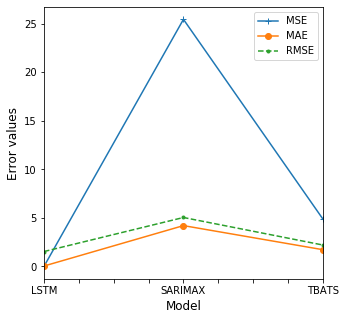

In [0]:

import matplotlib.pyplot as plt
import pandas as pd

# gca stands for 'get current axis'

ax = Performance_Evaluation.plot(style=['+-','o-','.--'],figsize = (5, 5))
ax.set_xlabel("Model", fontsize=12)
ax.set_ylabel("Error values", fontsize=12)

plt.show()


## ***SARIMA Implementation***



p is the order of the AR term.
q is the order of the MA term.
d is the number of differencing required to make the time series stationary.

In [0]:
# Import
# data = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

data = df_cork_notnull[['date','temp']].copy()
data=data.set_index('date',inplace=False)
data.head()


,temp
date,
1989-01-01 00:00:00,9.1
1989-01-01 01:00:00,9.0
1989-01-01 02:00:00,8.9
1989-01-01 03:00:00,9.0
1989-01-01 04:00:00,9.0


In [0]:
data = data.rolling(5).mean().resample('D').first()

In [0]:
#### P vlaue is <0.005 so time Series is Stationary and d which is differnencing value is 0 


from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(data.temp.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -6.691044
p-value: 0.000000


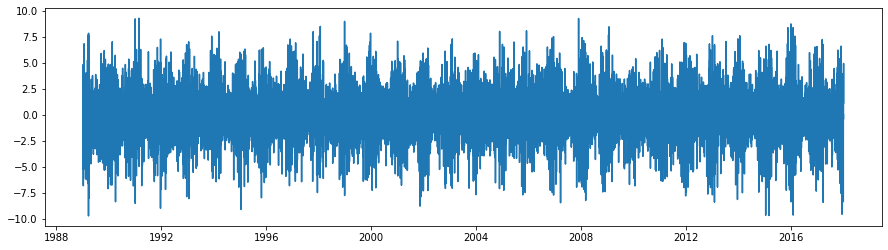

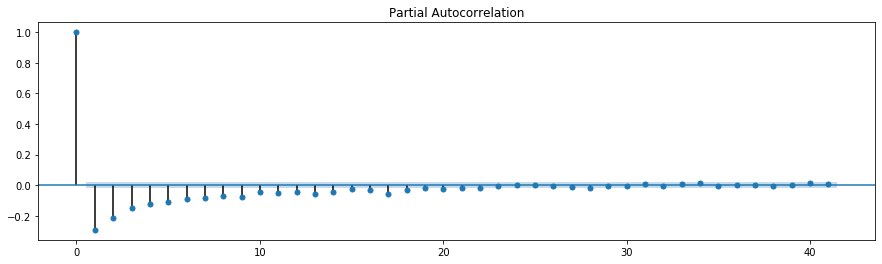

In [0]:
# PACF values

# How to find the order of the AR term (p)

# plt.rcParams.update({'figure.figsize':(15,3), 'figure.dpi':120})
# fig, axes = plt.subplots(1, 2, sharex=True)

plt.plot(data.temp.diff()); 

plot_pacf(data.temp.diff().dropna())

plt.show()


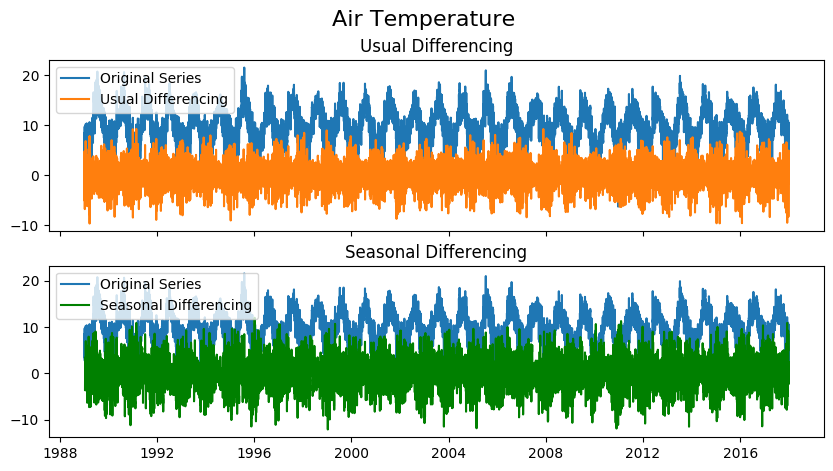

In [0]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(data[:], label='Original Series')
axes[0].plot(data[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(data[:], label='Original Series')
axes[1].plot(data[:].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Air Temperature', fontsize=16)
plt.show()

In [0]:
#divide into train and validation set
train = data[:int(0.8*(len(data)))]
valid = data[int(0.8*(len(data))):]

#plotting the data
train['temp'].plot()
valid['temp'].plot()

In [0]:
# pip install pmdarima
import pmdarima as pm
# Seasonal - fit stepwise auto-ARIMA

smodel = pm.auto_arima(train, start_p=1, start_q=1,
                          # test='adf',
                         max_p=3, max_q=3, h=24,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)
smodel.summary()

In [0]:
# Forecast
n_periods = len(valid)
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(train.index[-1], periods = n_periods, freq='D')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Time series AIR Temperature")
plt.show()

In [0]:
fitted_series.tail(10)

In [0]:
valid.tail(10)

###***Accuracy Metrics***

In [0]:

# Mean forecast Error 
forecast_errors = [valid[i]-fitted[i] 
                   for i in range(len(valid))]
bias = sum(forecast_errors) * 1.0/len(valid)
print('Bias: %f' % bias)


In [0]:
from sklearn.metrics import mean_absolute_error

# Mean Absolute Error
mae = mean_absolute_error(valid, fitted)
print('MAE: %f' % mae)





In [0]:
from sklearn.metrics import mean_squared_error
# Mean Squared Error

mse = mean_squared_error(valid, fitted)
print('MSE: %f' % mse)


In [0]:
from sklearn.metrics import mean_squared_error

# Root Mean square error

mse = mean_squared_error(valid, fitted)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)
